In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='SQL3306Server!!',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Aayush/Documents/SQL Server Management Studio/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(host ="localhost",
                            username ="root",
                            password ="SQL3306Server!!",
                            database = "ecommerce")

cur = db.cursor()



## List all unique cities where customers are located.

In [29]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=['City'])

df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## Count the number of orders placed in 2017.

In [22]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data =cur.fetchall()

data[0][0]

45101

## Find the total sales per category.

In [28]:
query = """select P.product_category, 
Round(sum(Q.payment_value),2) as total_sales
from products P
join order_items O 
on P.product_id = O.product_id
Join payments Q
on Q.order_id = O.order_id
Group by P.product_category
order by total_sales DESC"""

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales'])

df

,Category,Sales
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68
...,...,...
69,PC Gamer,2174.43
70,House Comfort 2,1710.54
71,cds music dvds,1199.43
72,Fashion Children's Clothing,785.67


## Calculate the percentage of orders that were paid in installments.

In [30]:
query = """SELECT 
    ((SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*)) * 100 AS order_percentage
FROM
    payments"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

## Count the number of customers from each state.

In [33]:
query = """select customer_state, count(customer_id)
    from customers
    Group By customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['State','Number of Customer'])
df = df.sort_values(by='Number of Customer', ascending = False)


In [34]:
df

,State,Number of Customer
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045
1,SC,3637
9,BA,3380
13,DF,2140
8,ES,2033
7,GO,2020


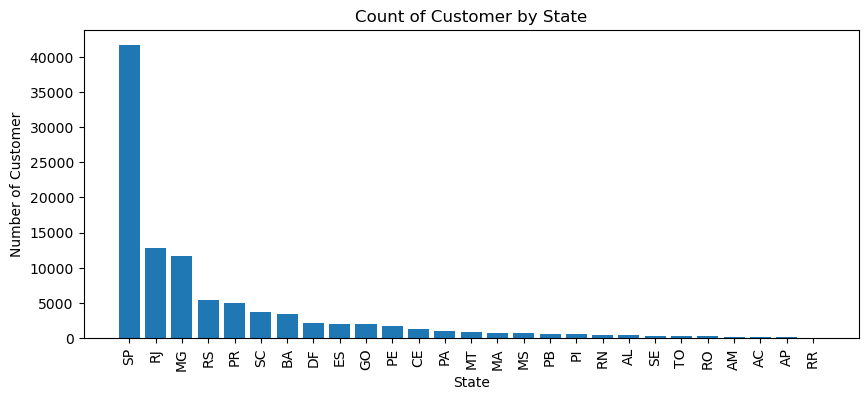

In [36]:
plt.figure(figsize=(10,4))
plt.bar(df['State'],df['Number of Customer'])
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Number of Customer')
plt.title('Count of Customer by State')
plt.show()

## Calculate the number of orders per month in 2018.

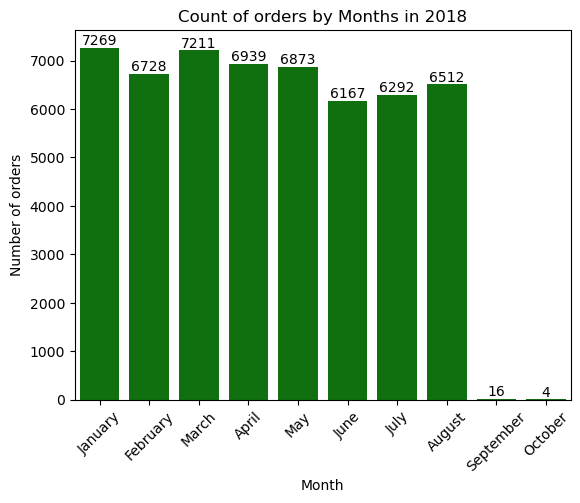

In [38]:
query = """SELECT 
    MONTHNAME(order_purchase_timestamp) AS month,
    COUNT(order_id)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY month"""

cur.execute(query)

data = cur.fetchall()

df  = pd.DataFrame(data, columns=['Month','Number of orders'])

o = ["January", "February","March","April","May","June","July","August","September","October"]


ax = sns.barplot(x = df['Month'],y = df['Number of orders'],data = df, order = o, color = 'green')

plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('Count of orders by Months in 2018')

plt.show()

In [5]:
query = """With count_order as(
select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)
Select customers.customer_city, Round(avg(count_order.order_count),2) as avg_order
from count_order
join customers
on count_order.customer_id = customers.customer_id
group by  customers.customer_city
order by avg_order DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['City','Average order'])
df

,City,Average order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
...,...,...
4105,sao mamede,4.00
4106,sambaiba,4.00
4107,japaratuba,4.00
4108,tuiuti,4.00


## Calculate the percentage of total revenue contributed by each product category.

In [6]:
query = """SELECT 
    products.product_category,
    ROUND((SUM(payments.payment_value) / (SELECT 
                    SUM(payment_value)
                FROM
                    payments)) * 100,
            2) AS percent_cont
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY products.product_category
ORDER BY percent_cont DESC"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales Distribution'])

df

,Category,Sales Distribution
0,bed table bath,42.79
1,HEALTH BEAUTY,41.41
2,computer accessories,39.61
3,Furniture Decoration,35.73
4,Watches present,35.71
...,...,...
69,PC Gamer,0.05
70,House Comfort 2,0.04
71,cds music dvds,0.03
72,Fashion Children's Clothing,0.02


## Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query = """SELECT 
    products.product_category,
    COUNT(order_items.product_id) order_count,
    Round(AVG(order_items.price),2) price
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','order_count','price'])

arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef([arr1,arr2])

print('The correlation betwwen product price and number of times a product has been purchased is ',a[0][-1])

The correlation betwwen product price and number of times a product has been purchased is  -0.10631514167157562


##  Calculate the total revenue generated by each seller, and rank them by revenue.

In [20]:
query = """With  top_seller As
(
SELECT 
    order_items.seller_id,
    ROUND(SUM(payments.payment_value), 2) AS total_revenue
FROM
    order_items
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id

)
Select *, Rank() over(order by total_revenue DESC) as seller_rank
from top_seller"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Sellers','Revenue','Rank'])

df.head(8)



,Sellers,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1088877.28,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1056664.48,7
7,955fee9216a65b617aa5c0531780ce60,945289.20,8


###  Calculate the moving average of order values for each customer over their order history.

In [24]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(
SELECT 
    orders.customer_id,
    orders.order_purchase_timestamp,
    payments.payment_value AS payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id','order_purchase_timestamp','payment','moving average'])
df

,customer_id,order_purchase_timestamp,payment,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


##  Calculate the cumulative sales per month for each year.

In [18]:
query = """select year, month, value,
sum(value) over(order by year, month) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as year,
month(orders.order_purchase_timestamp) as month,
Round(sum(payments.payment_value),2) as value
from orders
join payments 
on orders.order_id = payments.order_id
group by year, month 
order by year, month) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','month','sales','cumulative sales'])
df

,year,month,sales,cumulative sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


## Calculate the year-over-year growth rate of total sales.

In [21]:
query = """with sales_rate as(
SELECT 
    YEAR(orders.order_purchase_timestamp) AS year,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY year
)
select year, sales, ((sales - lag(sales,1) over (order by year)) / lag(sales,1) over(order by year))*100 as year_growth_rate
from sales_rate"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','sales','YOY % growth'])
df

,year,sales,YOY % growth
0,2016,237449.36,NaN
1,2017,28998986.91,12112.703757
2,2018,34799052.21,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [25]:
query = """With a as(
SELECT 
    customers.customer_id,
    MIN(orders.order_purchase_timestamp) AS first_order
FROM
    customers
        JOIN
    orders ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id 
),
b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a
join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and  orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id
)
select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) as retention_rate
from a left join b 
on a.customer_id = b.customer_id"""

cur.execute(query)

data = cur.fetchall()


data

[(None,)]

## Identify the top 3 customers who spent the most money in each year.

In [22]:
query = """With top_customers as(
select  *, 
rank() over(partition by year order by year, indi_purchase DESC) as cust_rank
from(
select year(orders.order_purchase_timestamp) year,
orders.customer_id, sum(payments.payment_value) as indi_purchase
from orders
join payments
on orders.order_id = payments.order_id
group by year, orders.customer_id) as a
)
select *
from top_customers
where cust_rank<=3"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','customer','payment','rank'])
df

,year,customer,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,5694.200195,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,5602.959961,2
2,2016,4a06381959b6670756de02e07b83815f,4911.120117,3
3,2017,1617b1357756262bfa56ab541c47bc16,54656.320312,1
4,2017,c6e2731c5b391845f6800c97401a43a9,27717.240234,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,26906.640625,3
6,2018,ec5b2ba62e574342386871631fafd3fc,29099.519531,1
7,2018,f48d464a0baaea338cb25f816991ab1f,27688.839844,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,19237.759766,3


<function matplotlib.pyplot.show(close=None, block=None)>

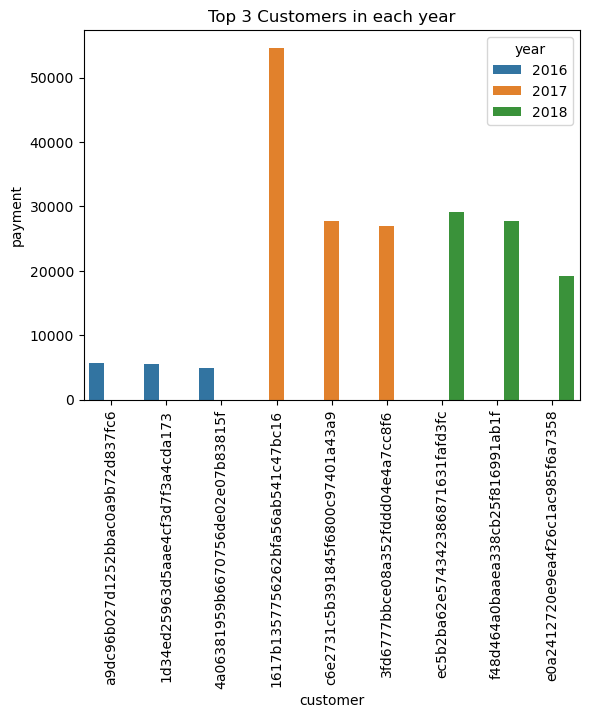

In [23]:
sns.barplot(x='customer',y='payment',data=df, hue='year')
plt.title('Top 3 Customers in each year')
plt.xticks(rotation = 90)
plt.show